In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

In [1]:
# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd cs231n/datasets/
!bash get_datasets.sh
%cd -

/home/pchen/Desktop/cs241n/assn/assignment1/cs231n/datasets
/home/pchen/Desktop/cs241n/assn/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
regularization_strengths = [5e1, 5e2, 5e3, 5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                              num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val_pred == y_val)
        results[(lr, rs)] = (np.mean(y_train_pred == y_train), val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

iteration 0 / 1500: loss 9.072692
iteration 100 / 1500: loss 9.089574
iteration 200 / 1500: loss 9.073639
iteration 300 / 1500: loss 9.079808
iteration 400 / 1500: loss 9.087940
iteration 500 / 1500: loss 9.091508
iteration 600 / 1500: loss 9.069321
iteration 700 / 1500: loss 9.081498
iteration 800 / 1500: loss 9.075207
iteration 900 / 1500: loss 9.064203
iteration 1000 / 1500: loss 9.096076
iteration 1100 / 1500: loss 9.074369
iteration 1200 / 1500: loss 9.073273
iteration 1300 / 1500: loss 9.074823
iteration 1400 / 1500: loss 9.080192
iteration 0 / 1500: loss 9.760394
iteration 100 / 1500: loss 9.776673
iteration 200 / 1500: loss 9.768869
iteration 300 / 1500: loss 9.766851
iteration 400 / 1500: loss 9.765229
iteration 500 / 1500: loss 9.765136
iteration 600 / 1500: loss 9.765199
iteration 700 / 1500: loss 9.754541
iteration 800 / 1500: loss 9.753535
iteration 900 / 1500: loss 9.752578
iteration 1000 / 1500: loss 9.752137
iteration 1100 / 1500: loss 9.760515
iteration 1200 / 1500: lo

iteration 400 / 1500: loss 9.000025
iteration 500 / 1500: loss 9.000013
iteration 600 / 1500: loss 9.000025
iteration 700 / 1500: loss 9.000011
iteration 800 / 1500: loss 9.000014
iteration 900 / 1500: loss 9.000027
iteration 1000 / 1500: loss 9.000016
iteration 1100 / 1500: loss 9.000008
iteration 1200 / 1500: loss 9.000023
iteration 1300 / 1500: loss 9.000025
iteration 1400 / 1500: loss 9.000018
iteration 0 / 1500: loss 737.400928
iteration 100 / 1500: loss 9.000036
iteration 200 / 1500: loss 9.000025
iteration 300 / 1500: loss 9.000035
iteration 400 / 1500: loss 9.000036
iteration 500 / 1500: loss 9.000033
iteration 600 / 1500: loss 9.000031
iteration 700 / 1500: loss 9.000027
iteration 800 / 1500: loss 9.000040
iteration 900 / 1500: loss 9.000040
iteration 1000 / 1500: loss 9.000037
iteration 1100 / 1500: loss 9.000035
iteration 1200 / 1500: loss 9.000041
iteration 1300 / 1500: loss 9.000032
iteration 1400 / 1500: loss 9.000035
iteration 0 / 1500: loss 7421.971570
iteration 100 / 1

/home/pchen/Desktop/cs241n/assn/assignment1/cs231n/classifiers/linear_svm.py:100: RuntimeWarning: overflow encountered in double_scalars
  loss = S.sum()/N + reg*np.sum(W**2)
/home/pchen/yes/envs/cs231n/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/pchen/Desktop/cs241n/assn/assignment1/cs231n/classifiers/linear_svm.py:100: RuntimeWarning: overflow encountered in square
  loss = S.sum()/N + reg*np.sum(W**2)
/home/pchen/Desktop/cs241n/assn/assignment1/cs231n/classifiers/linear_svm.py:117: RuntimeWarning: overflow encountered in multiply
  dW = X.T@S/N + reg*2*W
/home/pchen/Desktop/cs241n/assn/assignment1/cs231n/classifiers/linear_svm.py:96: RuntimeWarning: invalid value encountered in matmul
  XW = X@W


iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 9.077988
iteration 100 / 1500: loss 9.051891
iteration 200 / 1500: loss 9.051855
iteration 300 / 1500: loss 9.046925
iteration 400 / 1500: loss 9.031003
iteration 500 / 1500: loss 9.029138
iteration 600 / 1500: loss 9.020399
iteration 700 / 1500: loss 9.029305
iteration 800 / 1500: loss 9.024545
iteration 900 / 1500: loss 9.016511
iteration 1000 / 1500: loss 9.004886
iteration 1100 / 1500: loss 9.009422
iteration 1200 / 1500: loss 9.003752
iteration 1300 / 1500: loss 9.010012
iteration 1400 / 1500: loss 9.003558
iteration 0 / 1500: loss 9.734449
iteration 100 / 1500: loss 9.097495
iteration 200 / 1500: loss 9.014344
iteration 300 / 1500: loss 9.002104
iteration 400 / 1500: loss 9.000345
iteration 500 / 1500: loss 9.000139
iteration 600 / 1500: loss 9.000412
iteration 700 / 

/home/pchen/yes/envs/cs231n/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 82.828211
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 816.665025
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 150

/home/pchen/Desktop/cs241n/assn/assignment1/cs231n/classifiers/linear_svm.py:97: RuntimeWarning: invalid value encountered in subtract
  S = XW - XW[np.arange(N), y].reshape(-1, 1) + 1


iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
lr 1.000000e-08 reg 5.000000e+01 train accuracy: 0.095898 val accuracy: 0.097000
lr 1.000000e-08 reg 5.000000e+02 train accuracy: 0.082082 val accuracy: 0.081000
lr 1.000000e-08 reg 5.000000e+03 train accuracy: 0.095939 val accuracy: 0.079000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.109735 val accuracy: 0.101000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.080388 val accuracy: 0.083000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.081694 val accuracy: 0.090000
lr 1.000000e-07 reg 5.000000e+01 train accuracy: 0.143347 val accuracy: 0.132000
lr 1.000000e-07 reg 5.000000e+02 train accuracy: 0.089245 val accuracy: 0.083000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.128735 val accuracy: 0.121000
lr 1.000000e-07 re

In [8]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.122


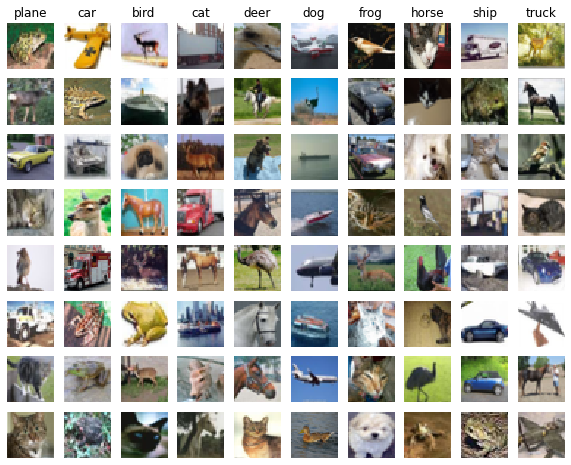

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ SVM doesn't work well on either raw pixels or extracted features. Counting on NN.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [10]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [68]:
data = {'X_train': X_train_feats,
        'y_train': y_train,
        'X_val': X_val_feats,
        'y_val': y_val,
        'X_test': X_test_feats,
        'y_test': y_test}

In [79]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

#model = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


lrs = [1e-3, 1e-6, 1e-9, 1e-12]
regs = [0, 5, 20, 100]
hds = [50, 100, 200]
best_acc = -1
for lr in lrs:
    for reg in regs:    
        for hd in hds:
            model = TwoLayerNet(input_dim, hd, num_classes, reg=reg)

            solver = Solver(model, data, update_rule='sgd', 
                            num_epochs=20, verbose=False, print_every=100,
                            optim_config={'learning_rate': lr})
            solver.train()
            res = 'lr: {}, reg: {}, val_acc: {}'.format(lr, reg, solver.best_val_acc)
            print(res)
            if solver.best_val_acc > best_acc:
                best_acc = solver.best_val_acc
                best_params = solver.best_params
                best_hyperp = {'lr': lr, 'reg': reg}
                best_net = model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


lr: 0.001, reg: 0, val_acc: 0.239
lr: 0.001, reg: 0, val_acc: 0.235
lr: 0.001, reg: 0, val_acc: 0.308
lr: 0.001, reg: 5, val_acc: 0.12
lr: 0.001, reg: 5, val_acc: 0.11
lr: 0.001, reg: 5, val_acc: 0.098
lr: 0.001, reg: 20, val_acc: 0.087
lr: 0.001, reg: 20, val_acc: 0.112
lr: 0.001, reg: 20, val_acc: 0.087
lr: 0.001, reg: 100, val_acc: 0.107
lr: 0.001, reg: 100, val_acc: 0.119
lr: 0.001, reg: 100, val_acc: 0.112
lr: 1e-06, reg: 0, val_acc: 0.111
lr: 1e-06, reg: 0, val_acc: 0.092
lr: 1e-06, reg: 0, val_acc: 0.076
lr: 1e-06, reg: 5, val_acc: 0.101
lr: 1e-06, reg: 5, val_acc: 0.075
lr: 1e-06, reg: 5, val_acc: 0.087
lr: 1e-06, reg: 20, val_acc: 0.101
lr: 1e-06, reg: 20, val_acc: 0.099
lr: 1e-06, reg: 20, val_acc: 0.101
lr: 1e-06, reg: 100, val_acc: 0.152
lr: 1e-06, reg: 100, val_acc: 0.094
lr: 1e-06, reg: 100, val_acc: 0.08
lr: 1e-09, reg: 0, val_acc: 0.092
lr: 1e-09, reg: 0, val_acc: 0.084
lr: 1e-09, reg: 0, val_acc: 0.08
lr: 1e-09, reg: 5, val_acc: 0.102
lr: 1e-09, reg: 5, val_acc: 0.104


In [80]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.292
